# Cleaning Data

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import datetime as dt
import os
import seaborn as sns

In [2]:
from scipy.optimize import newton

In [146]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
sns.set_theme()
sns.set_palette("tab20")
sns.set_style("darkgrid", rc = {"grid.color": "white"})
c10 = sns.color_palette("tab10").as_hex()[:]
c20 = sns.color_palette("tab20").as_hex()[:]

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
os.chdir('/Users/maris/Documents/FE800')

## Import Data

In [9]:
raw_data = pd.read_pickle("raw_data.pkl")
raw_data = raw_data.sort_values("trd_datetime")
raw_data.head()

,cusip_id,bond_sym_id,company_symbol,bsym,trd_exctn_dt,trd_exctn_tm,trans_dt,msg_seq_nb,trc_st,remuneration,ascii_rptd_vol_tx,frmt_cd,rptd_pr,yld_sign_cd,yld_pt,asof_cd,sale_cndtn_cd,sale_cndtn2_cd,spcl_trd_fl,side,chng_cd,rptd_high_pr,high_yld_pt,rptd_low_pr,low_yld_pt,rptd_last_pr,lsal_yld_pt,orig_dis_dt,orig_msg_seq_nb,function,rptg_party_type,contra_party_type,trd_datetime
15069458,871829BF3,SYY4509019,SYY,BBG00GZTSD12,2018-07-01,23:50:32,2018-07-02,499,M,M,5000000.0,A,94.111,NaN,4.034690,A,NaN,NaN,NaN,S,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,C,2018-07-01 23:50:32
13757251,98978VAL7,PFE4538719,PFE,BBG00HMQT197,2018-07-02,01:17:48,2018-07-02,502,M,M,5000000.0,A,92.248,NaN,4.017301,NaN,NaN,NaN,NaN,S,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,C,2018-07-02 01:17:48
168819,037833DB3,AAPL4538816,AAPL,BBG00HMQPZ05,2018-07-02,02:37:16,2018-07-02,124,M,M,10000.0,A,95.090,NaN,3.530293,NaN,NaN,NaN,NaN,S,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,C,2018-07-02 02:37:16
12504563,606822AR5,MTU4520249,MTU,BBG00H5RFN00,2018-07-02,02:43:56,2018-07-02,503,M,M,100000.0,A,95.448,NaN,3.887961,NaN,NaN,NaN,NaN,S,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,A,2018-07-02 02:43:56
3857278,172967KA8,C4292071,C,BBG00B2XQKX1,2018-07-02,03:35:11,2018-07-02,574,M,M,110000.0,A,98.817,NaN,4.607907,NaN,NaN,NaN,NaN,S,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,A,2018-07-02 03:35:11


In [11]:
data = raw_data[["cusip_id", "trd_datetime", "trans_dt", "rptd_pr", "ascii_rptd_vol_tx"]]
data = data.rename(columns = {"cusip_id":"cusip", "rptd_pr":"trd_px", "ascii_rptd_vol_tx":"volume", "trans_dt":"trd_dt"})
data.head()

,cusip,trd_datetime,trd_dt,trd_px,volume
15069458,871829BF3,2018-07-01 23:50:32,2018-07-02,94.111,5000000.0
13757251,98978VAL7,2018-07-02 01:17:48,2018-07-02,92.248,5000000.0
168819,037833DB3,2018-07-02 02:37:16,2018-07-02,95.090,10000.0
12504563,606822AR5,2018-07-02 02:43:56,2018-07-02,95.448,100000.0
3857278,172967KA8,2018-07-02 03:35:11,2018-07-02,98.817,110000.0


In [12]:
df_characteristics = pd.read_pickle("df_characteristics.pkl")
df_characteristics = df_characteristics.drop(["Notional", "Par", "Sector_LQD", "Location", "Liquidity_Score"], axis = 1)
df_characteristics = df_characteristics.rename(columns = {'Sector_BB':'Sector'})
df_characteristics.head()

,Company,Cusip,Maturity,TTM,Coupon,Weight,Amount_Issued,Sector,Accrual_Date,Effective_Date,Moody_Rating,S&P_Rating,Fitch_Rating,TTM_Range
0,PFIZER INVESTMENT ENTERPRISES PTE,716973AG7,2053-05-19,29.6000,5.30,0.30,6000000000,"Consumer, Non-cyclical",2023-05-19,2023-05-19,A1,A+,Au,20+ Years
1,ANHEUSER-BUSCH COMPANIES LLC,03522AAJ9,2046-02-01,22.3014,4.90,0.28,9518964000,"Consumer, Non-cyclical",2019-02-01,2019-05-13,A3,A-,WD,20+ Years
2,GOLDMAN SACHS GROUP INC/THE,38141GFD1,2037-10-01,13.9589,6.75,0.25,5545000000,Financial,2007-10-03,2007-10-03,Baa2,BBB,BBB+,10-15 Years
3,CVS HEALTH CORP,126650CZ1,2048-03-25,24.4466,5.05,0.22,8000000000,"Consumer, Non-cyclical",2018-03-09,2018-03-09,Baa2,BBB,NaN,20+ Years
4,T-MOBILE USA INC,87264ABF1,2030-04-15,6.4904,3.88,0.21,7000000000,Communications,2021-04-15,2021-05-21,Baa2,BBB,BBB+,5-7 Years


In [13]:
macro_factors = pd.read_pickle("macro_factors.pkl")
macro_factors.head()

,EFFR,Lower_Target,Upper_Target,1YRT,2YRT,3YRT,5YRT,7YRT,10YRT,30YRT,Unemployment,CPI,PCE,IPI,GDP,Real_GDP_cap
2018-07-02,1.91,1.75,2.0,2.34,2.57,2.65,2.75,2.83,2.87,2.99,3.8,2.519634,5.36443,3.23564,1.05835,0.46628
2018-07-03,1.91,1.75,2.0,2.33,2.53,2.63,2.72,2.79,2.83,2.96,3.8,2.519634,5.36443,3.23564,1.05835,0.46628
2018-07-05,1.91,1.75,2.0,2.32,2.55,2.65,2.74,2.80,2.84,2.95,3.8,2.519634,5.36443,3.23564,1.05835,0.46628
2018-07-06,1.91,1.75,2.0,2.34,2.53,2.64,2.71,2.78,2.82,2.94,3.8,2.519634,5.36443,3.23564,1.05835,0.46628
2018-07-09,1.91,1.75,2.0,2.34,2.57,2.66,2.75,2.82,2.86,2.96,3.8,2.519634,5.36443,3.23564,1.05835,0.46628


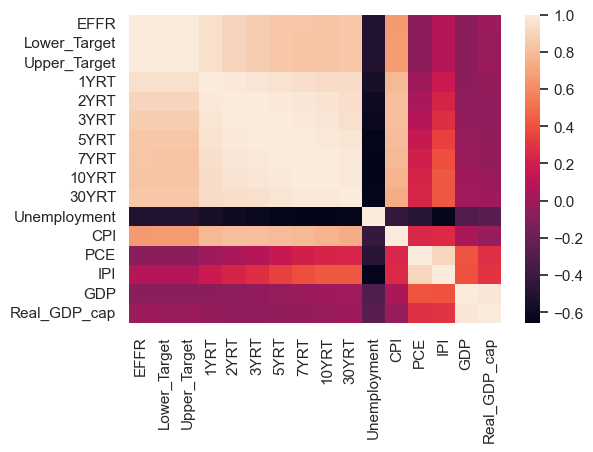

In [161]:
plt.figure(figsize = [6,4])
sns.heatmap(macro_factors.corr(), annot = False)
plt.show()

# Daily Data 

In [15]:
daily_close_prices = data.groupby(["cusip", "trd_dt"])["trd_px"].agg({"last"})
daily_close_prices.head()

last
cusip     trd_dt             
00130HCG8 2021-08-16  101.067
          2021-08-20  101.009
          2021-08-23  101.369
          2021-08-24  101.395
          2021-08-25  100.530

In [16]:
df_daily = daily_close_prices.unstack("cusip")
df_daily = df_daily.sort_index()
df_daily.columns = df_daily.columns.droplevel(0)
df_daily = df_daily.replace(.1, 147.647)
df_daily = df_daily.ffill()
df_daily.head()

cusip       00130HCG8  00130HCH6  00206RBH4  00206RBK7  00206RCP5  00206RCQ3  \
trd_dt                                                                         
2018-07-02        NaN        NaN     86.132  85.280000     92.446    91.4532   
2018-07-03        NaN        NaN     86.821  85.863000     93.350    90.3120   
2018-07-05        NaN        NaN     86.730  85.979573     93.282    92.2920   
2018-07-06        NaN        NaN     88.675  86.610000     93.000    91.0250   
2018-07-09        NaN        NaN     89.397  87.282000     93.380    91.4124   

cusip        00206RCU4  00206RDJ8  00206RDK5   00206RDQ2   00206RDR0  \
trd_dt                                                                 
2018-07-02  100.697000  88.308500  86.652000   98.191000   98.845000   
2018-07-03  101.772049  86.951288  86.373563   98.533103   99.710000   
2018-07-05  102.214000  87.437000  87.390000   99.932742  100.278997   
2018-07-06  102.214000  87.760000  88.016000   98.881000  100.236000   
2018-07-09  102.635000  88.315000  88.016000  100.233900  100.858000   

cusip       00206RGL0  00206RGQ9  00206RHJ4  00206RHK1  00206RHW5  00206RJX1  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00206RJY9  00206RJZ6  00206RKA9  00206RKB7  00206RKE1  00206RKG6  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00206RKH4  00206RKJ0  00206RLJ9  00206RLV2  00206RMM1  00206RMN9  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00206RMT6  00217GAB9  00217GAC7  002824BF6  002824BG4   002824BH2  \
trd_dt                                                                          
2018-07-02        NaN        NaN        NaN     98.213    105.716  107.826000   
2018-07-03        NaN        NaN        NaN     98.600    106.012  108.997437   
2018-07-05        NaN        NaN        NaN     98.601    106.840  109.156000   
2018-07-06        NaN        NaN        NaN     99.101    107.087  109.845000   
2018-07-09        NaN        NaN        NaN     98.947    107.073  110.156000   

cusip       00287YAM1  00287YAR0  00287YAS8  00287YAV1  00287YAW9  00287YBD0  \
trd_dt                                                                         
2018-07-02     95.296     98.118     99.255  95.429000     95.198        NaN   
2018-07-03     95.393     98.382     99.255  96.102142     95.198        NaN   
2018-07-05     96.091     99.409     99.767  96.466230     96.431        NaN   
2018-07-06     96.091     99.609     99.767  97.300000     96.632        NaN   
2018-07-09     95.883     99.213     99.767  99.190000     96.905        NaN   

cusip       00287YBF5  00287YBV0  00287YBX6  00287YCA5  00287YCB3  00287YCY3  \
trd_dt                                    

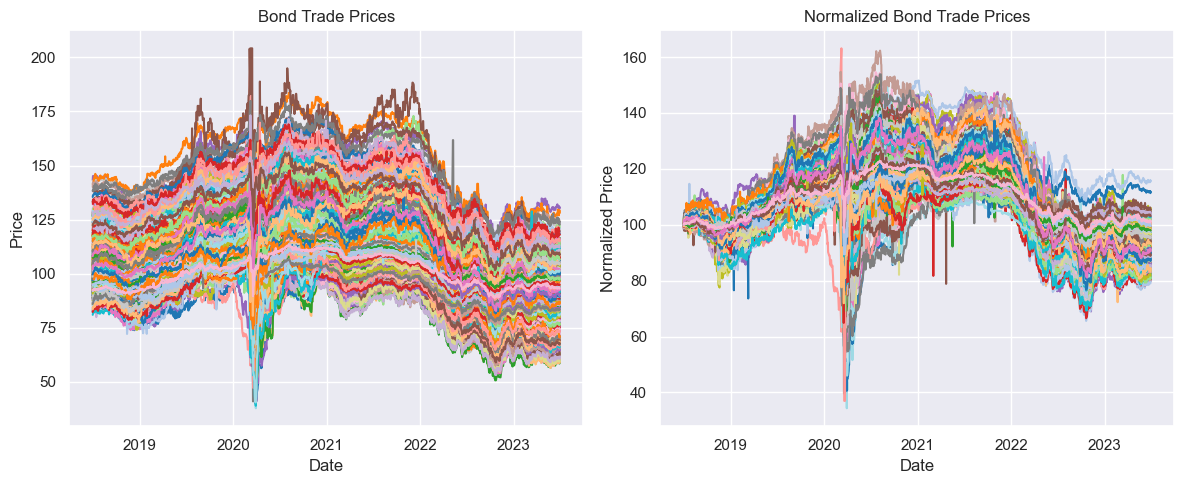

In [17]:
fig, ax = plt.subplots(1, 2, figsize = [12,5])

ax[0].plot(df_daily)
ax[0].set_title("Bond Trade Prices")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")
ax[0].grid(True)

ax[1].plot(df_daily/df_daily.iloc[0] * 100)
ax[1].set_title("Normalized Bond Trade Prices")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Normalized Price")
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [18]:
df_daily_returns = df_daily.pct_change()
df_daily_returns.head()

cusip       00130HCG8  00130HCH6  00206RBH4  00206RBK7  00206RCP5  00206RCQ3  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN   0.007999   0.006836   0.009779  -0.012479   
2018-07-05        NaN        NaN  -0.001048   0.001358  -0.000728   0.021924   
2018-07-06        NaN        NaN   0.022426   0.007332  -0.003023  -0.013728   
2018-07-09        NaN        NaN   0.008142   0.007759   0.004086   0.004256   

cusip       00206RCU4  00206RDJ8  00206RDK5  00206RDQ2  00206RDR0  00206RGL0  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03   0.010676  -0.015369  -0.003213   0.003484   0.008751        NaN   
2018-07-05   0.004343   0.005586   0.011768   0.014205   0.005707        NaN   
2018-07-06   0.000000   0.003694   0.007163  -0.010524  -0.000429        NaN   
2018-07-09   0.004119   0.006324   0.000000   0.013682   0.006205        NaN   

cusip       00206RGQ9  00206RHJ4  00206RHK1  00206RHW5  00206RJX1  00206RJY9  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00206RJZ6  00206RKA9  00206RKB7  00206RKE1  00206RKG6  00206RKH4  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00206RKJ0  00206RLJ9  00206RLV2  00206RMM1  00206RMN9  00206RMT6  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00217GAB9  00217GAC7  002824BF6  002824BG4  002824BH2  00287YAM1  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN   0.003940   0.002800   0.010864   0.001018   
2018-07-05        NaN        NaN   0.000010   0.007810   0.001455   0.007317   
2018-07-06        NaN        NaN   0.005071   0.002312   0.006312   0.000000   
2018-07-09        NaN        NaN  -0.001554  -0.000131   0.002831  -0.002165   

cusip       00287YAR0  00287YAS8  00287YAV1  00287YAW9  00287YBD0  00287YBF5  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03   0.002691   0.000000   0.007054   0.000000        NaN        NaN   
2018-07-05   0.010439   0.005158   0.003789   0.012952        NaN        NaN   
2018-07-06   0.002012   0.000000   0.008643   0.002084        NaN        NaN   
2018-07-09  -0.003976   0.000000   0.019424   0.002825        NaN        NaN   

cusip       00287YBV0  00287YBX6  00287YCA5  00287YCB3  00287YCY3  00287Y

## Daily Bond Factors

In [19]:
def ytm(price, ttm, c):

    periods = int(ttm * 2) + 1
    extra_time = ttm - int(ttm * 2)/2
    coupon = c * 100/2
    time = [np.round((i/2) + extra_time, 4) for i in range(periods)]
    
    def f(y):
        return sum([coupon*np.exp(-t*y) for t in time]) + 100*np.exp(-y*ttm) - price
    
    return newton(f, c)

In [20]:
def PV(price, ttm, c):

    periods = int(ttm * 2) + 1
    extra_time = ttm - int(ttm * 2)/2
    coupon = c * 100/2
    y = ytm(price, ttm, c)

    df = pd.DataFrame()
    df["Time"] = [np.round((i/2) + extra_time, 4) for i in range(periods)]
    df = df[df["Time"] > 0]
    df["Cash Flow"] = coupon
    df["Cash Flow"].iloc[-1] = coupon + 100
    df["PV"] = df["Cash Flow"] * np.exp(-y * df["Time"])

    return sum(df["PV"])

In [21]:
def macaulay_duration(price, ttm, c):

    periods = int(ttm * 2) + 1
    extra_time = ttm - int(ttm * 2)/2
    coupon = c * 100/2
    y = ytm(price, ttm, c)

    df = pd.DataFrame()
    df["Time"] = [np.round((i/2) + extra_time, 4) for i in range(periods)]
    df = df[df["Time"] > 0]
    df["Cash Flow"] = coupon
    df["Cash Flow"].iloc[-1] = coupon + 100
    df["PV"] = df["Cash Flow"] * np.exp(-y * df["Time"])
    df["Weight"] = df["PV"]/sum(df["PV"]) 

    duration = sum(df["Weight"]*df["Time"])
    return duration

In [22]:
def DV01(price, ttm, c):
    return -1 * price * macaulay_duration(price, ttm, c) * .001

In [23]:
def convexity(price, ttm, c):

    periods = int(ttm * 2) + 1
    extra_time = ttm - int(ttm * 2)/2
    coupon = c * 100/2
    y = ytm(price, ttm, c)

    df = pd.DataFrame()
    df["Time"] = [np.round((i/2) + extra_time, 4) for i in range(periods)]
    df = df[df["Time"] > 0]
    df["Cash Flow"] = coupon
    df["Cash Flow"].iloc[-1] = coupon + 100
    df["PV"] = df["Cash Flow"] * np.exp(-y * df["Time"])
    df["Weight"] = df["PV"]/sum(df["PV"]) 

    convexity = sum(df["Weight"]*(df["Time"]**2))
    return convexity

## Bond Level Factors

In [24]:
def illiquidity(bond):
    df = pd.DataFrame({"Price": bond})
    df["delta_t"] = df["Price"] - df["Price"].shift(1)
    df["delta_t1"] = df["Price"].shift(-1) - df["Price"]
    return -df["delta_t"].cov(df["delta_t1"])

In [25]:
def roll_illiquidity(bond):
    df = pd.DataFrame({"Price": bond})
    df["rd"] = df["Price"] - df["Price"].shift(1)
    df["rd1"] = df["rd"].shift()
    cov = -df["rd"].cov(df["rd1"])
    if cov < 0:
        return 0
    else:
        return 2*np.sqrt(cov)

In [38]:
df_bond_factors = pd.DataFrame({"cusip": df_daily.columns})
df_bond_factors["Illiquidity"] = df_bond_factors["cusip"].apply(lambda x: illiquidity(df_daily[x]))
df_bond_factors["Roll"] = df_bond_factors["cusip"].apply(lambda x: roll_illiquidity(df_daily[x]))
df_bond_factors["Roll_Intraday"] = df_bond_factors["cusip"].apply(lambda x: roll_illiquidity(data[data["cusip"] == x]["trd_px"]))
df_bond_factors.head()

,cusip,Illiquidity,Roll,Roll_Intraday
0,00130HCG8,0.005285,0.145399,0.381294
1,00130HCH6,0.150137,0.774951,0.926653
2,00206RBH4,0.287334,1.072070,1.101126
3,00206RBK7,0.222489,0.943375,1.122904
4,00206RCP5,0.360659,1.201097,1.244290


In [44]:
def zero_return(returns):
    df = pd.DataFrame({"Returns": returns})
    return len(df[df["Returns"] == 0])/len(returns)

In [46]:
df_bond_factors["Zero_Return"] =  df_bond_factors["cusip"].apply(lambda x: zero_return(df_daily_returns[x]))
df_bond_factors.head()

,cusip,Illiquidity,Roll,Roll_Intraday,Zero_Return
0,00130HCG8,0.005285,0.145399,0.381294,0.032617
1,00130HCH6,0.150137,0.774951,0.926653,0.000000
2,00206RBH4,0.287334,1.072070,1.101126,0.008751
3,00206RBK7,0.222489,0.943375,1.122904,0.024662
4,00206RCP5,0.360659,1.201097,1.244290,0.003978


# Case Study: Pricing Single Bonds

In [244]:
def bond_dataset(cusip, ticker):
    
    df_cusip = pd.DataFrame({"Price": df_daily[cusip]})
    df_cusip["Return"] = df_cusip.pct_change()
    df_cusip["Volume"] = data[data["cusip"] == cusip][["trd_dt", "volume"]].groupby("trd_dt").sum()
    df_cusip["Trades"] = data[data["cusip"] == cusip][["trd_dt", "volume"]].groupby("trd_dt").count()
    df_cusip["Age"] = df_cusip.index.map(lambda x: (x - cusip_info["Effective_Date"][0]).days/365)
    df_cusip["TTM"] = df_cusip.index.map(lambda x: (cusip_info["Maturity"][0] - x).days/365)
    df_cusip["PV"] = df_cusip.apply(lambda x: PV(x["Price"], x["TTM"], cusip_info["Coupon"][0]), axis = 1)
    df_cusip["YTM"] = df_cusip.apply(lambda x: ytm(x["Price"], x["TTM"], cusip_info["Coupon"][0]), axis = 1)
    df_cusip["Duration"] = df_cusip.apply(lambda x: macaulay_duration(x["Price"], x["TTM"], cusip_info["Coupon"][0]), axis = 1)
    df_cusip["DV01"] = df_cusip.apply(lambda x: DV01(x["Price"], x["TTM"], cusip_info["Coupon"][0]), axis = 1)
    df_cusip["Convexity"] = df_cusip.apply(lambda x: convexity(x["Price"], x["TTM"], cusip_info["Coupon"][0]), axis = 1)
    df_cusip["Stock"] = yf.download(ticker, "2018-07-02", "2023-06-30")["Adj Close"].diff()

    return df_cusip

In [200]:
def plot_bond(cusip):

    fig, ax = plt.subplots(2, 2, figsize = [12,8])

    ax[0,0].plot(data[data["cusip"] == cusip]["trd_datetime"], 
                 data[data["cusip"] == cusip]["trd_px"], 
                 label = "Trade Prices", color = c20[0])
    ax[0,0].plot(df_daily[cusip], label = "Daily Close Price", color = c20[1])
    ax[0,0].set_title("CVS 4.3% 3/2028 10Y Bond")
    ax[0,0].set_xlabel("Date")
    ax[0,0].set_ylabel("Price")
    ax[0,0].legend(loc = "lower left")

    ax[0,1].hist(df_daily_returns[cusip], bins = 50, color = c20[0])
    ax[0,1].set_title("CVS 4.3% 3/2028 10Y Bond Daily Returns")
    ax[0,1].set_xlabel("Daily Return")

    df = df_daily[cusip].diff()
    df.iloc[0] = 0
    plot_acf(df, lags=50, ax=ax[1, 0])

    ax[1,1].plot(df_daily_returns.index, df_daily_returns[cusip], color = c20[0])
    ax[1,1].set_title("Daily Returns")
    ax[1,1].set_xlabel("Daily Return")

    plt.tight_layout()
    plt.show()

## CVS: 126650CX6

In [178]:
cusip_126650CX6 = "126650CX6"

In [179]:
cusip_info = df_characteristics[df_characteristics["Cusip"] == cusip_126650CX6].reset_index().drop(["index"], axis = 1)
cusip_info["Coupon"] = cusip_info["Coupon"]/100
cusip_info

,Company,Cusip,Maturity,TTM,Coupon,Weight,Amount_Issued,Sector,Accrual_Date,Effective_Date,Moody_Rating,S&P_Rating,Fitch_Rating,TTM_Range
0,CVS HEALTH CORP,126650CX6,2028-03-25,4.4329,0.043,0.15,7495129000,Communications,2018-03-09,2018-03-09,Baa2,BBB,BBB+,3-5 Years


In [180]:
data[data["cusip"] == cusip_126650CX6].sort_values("trd_datetime").reset_index().drop(["index"], axis = 1).head()

,cusip,trd_datetime,trd_dt,trd_px,volume
0,126650CX6,2018-07-02 09:35:21,2018-07-02,98.623,250000.0
1,126650CX6,2018-07-02 09:39:08,2018-07-02,98.610,150000.0
2,126650CX6,2018-07-02 09:39:08,2018-07-02,98.610,150000.0
3,126650CX6,2018-07-02 10:27:19,2018-07-02,98.532,50000.0
4,126650CX6,2018-07-02 11:14:25,2018-07-02,98.576,760000.0


In [251]:
df_126650CX6 = bond_dataset(cusip_126650CX6, "CVS")
df_126650CX6.head()

[*********************100%%**********************]  1 of 1 completed


,Price,Return,Volume,Trades,Age,TTM,PV,YTM,Duration,DV01,Convexity,Stock
trd_dt,,,,,,,,,,,,
2018-07-02,98.516,NaN,16929000.0,36.0,0.315068,9.736986,98.515960,0.045831,7.939901,-0.782207,71.912689,NaN
2018-07-03,99.002,0.004933,1022000.0,11.0,0.317808,9.734247,99.002136,0.045227,7.942451,-0.786319,71.931038,-0.571808
2018-07-05,99.326,0.003273,16699000.0,47.0,0.323288,9.728767,99.325905,0.044846,7.940415,-0.788690,71.884754,0.503525
2018-07-06,99.544,0.002195,12763000.0,37.0,0.326027,9.726027,99.544079,0.044586,7.939916,-0.790371,71.867275,1.186283
2018-07-09,99.405,-0.001396,84086000.0,74.0,0.334247,9.717808,99.405024,0.044808,7.929752,-0.788257,71.714138,0.989983


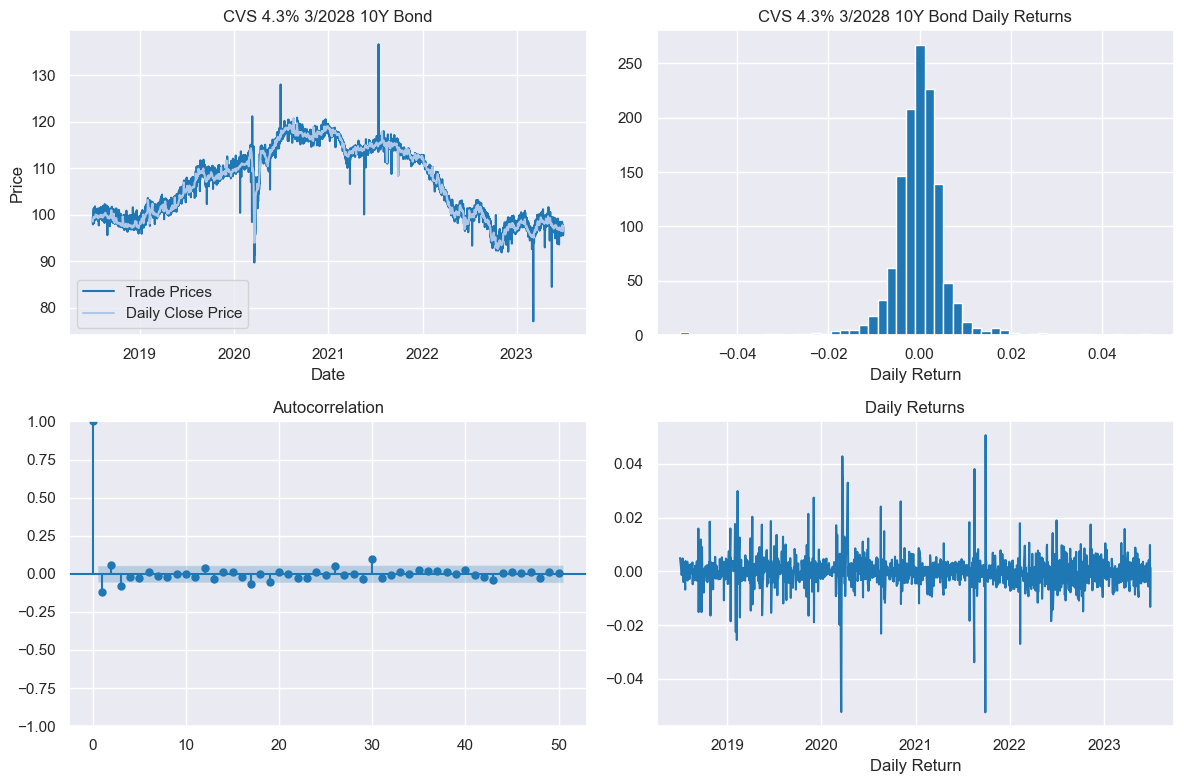

In [252]:
plot_bond(cusip_126650CX6)

In [253]:
df_126650CX6 = pd.concat([df_126650CX6, macro_factors], axis = 1)
df_126650CX6.head()

,Price,Return,Volume,Trades,Age,TTM,PV,YTM,Duration,DV01,Convexity,Stock,EFFR,Lower_Target,Upper_Target,1YRT,2YRT,3YRT,5YRT,7YRT,10YRT,30YRT,Unemployment,CPI,PCE,IPI,GDP,Real_GDP_cap
2018-07-02,98.516,NaN,16929000.0,36.0,0.315068,9.736986,98.515960,0.045831,7.939901,-0.782207,71.912689,NaN,1.91,1.75,2.0,2.34,2.57,2.65,2.75,2.83,2.87,2.99,3.8,2.519634,5.36443,3.23564,1.05835,0.46628
2018-07-03,99.002,0.004933,1022000.0,11.0,0.317808,9.734247,99.002136,0.045227,7.942451,-0.786319,71.931038,-0.571808,1.91,1.75,2.0,2.33,2.53,2.63,2.72,2.79,2.83,2.96,3.8,2.519634,5.36443,3.23564,1.05835,0.46628
2018-07-05,99.326,0.003273,16699000.0,47.0,0.323288,9.728767,99.325905,0.044846,7.940415,-0.788690,71.884754,0.503525,1.91,1.75,2.0,2.32,2.55,2.65,2.74,2.80,2.84,2.95,3.8,2.519634,5.36443,3.23564,1.05835,0.46628
2018-07-06,99.544,0.002195,12763000.0,37.0,0.326027,9.726027,99.544079,0.044586,7.939916,-0.790371,71.867275,1.186283,1.91,1.75,2.0,2.34,2.53,2.64,2.71,2.78,2.82,2.94,3.8,2.519634,5.36443,3.23564,1.05835,0.46628
2018-07-09,99.405,-0.001396,84086000.0,74.0,0.334247,9.717808,99.405024,0.044808,7.929752,-0.788257,71.714138,0.989983,1.91,1.75,2.0,2.34,2.57,2.66,2.75,2.82,2.86,2.96,3.8,2.519634,5.36443,3.23564,1.05835,0.46628


In [254]:
X = df_126650CX6.drop(["Return", "Price"], axis = 1)[1:].ffill()
y = df_126650CX6["Return"][1:].fillna(0)

In [255]:
X0 = sm.add_constant(X)
model = sm.OLS(y, X0).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     3.052
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           1.16e-06
Time:                        23:13:18   Log-Likelihood:                 4621.0
No. Observations:                1271   AIC:                            -9192.
Df Residuals:                    1246   BIC:                            -9063.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0013      0.004     -0.369   

In [256]:
X_train = X.loc[:pd.Timestamp("2022-05-31")]
X_test = X.loc[pd.Timestamp("2022-06-01"):]
y_train = y.loc[:pd.Timestamp("2022-05-31")]
y_test = y.loc[pd.Timestamp("2022-06-01"):]

In [257]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

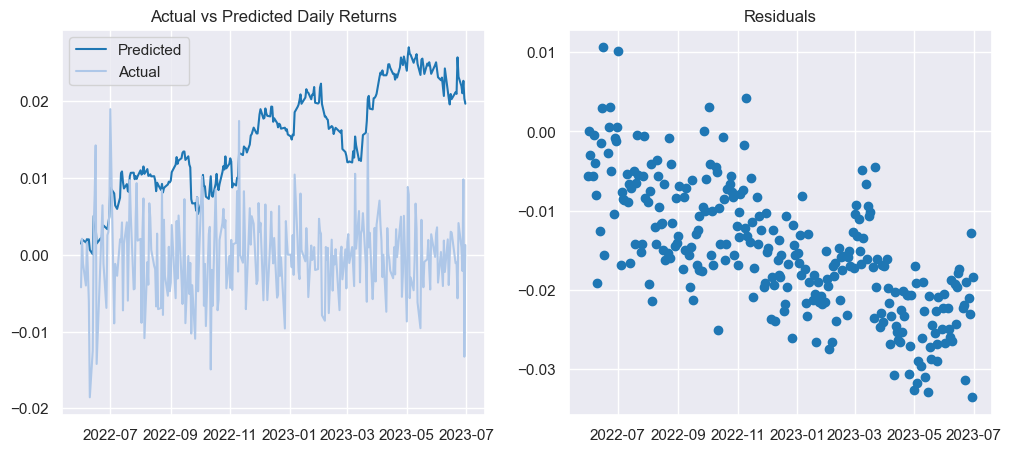

In [260]:
fig, ax = plt.subplots(1, 2, figsize = [12,5])

ax[0].plot(y_test.index, y_pred, label = "Predicted")
ax[0].plot(y_test.index, y_test, label = "Actual")
ax[0].set_title("Actual vs Predicted Daily Returns")
ax[0].legend()

ax[1].scatter(y_test.index, y_test - y_pred)
ax[1].set_title("Residuals")

plt.show()

In [229]:
mse = mean_squared_error(y_test, y_pred)
mse

0.0002586862246214236

In [230]:
r2 = r2_score(y_test, y_pred)
r2

-8.026795755257059

## MO: 02209SAV5

In [231]:
cusip_02209SAV5 = "02209SAV5"

In [232]:
df_characteristics[df_characteristics["Cusip"] == cusip_02209SAV5].reset_index().drop(["index"], axis = 1)

,Company,Cusip,Maturity,TTM,Coupon,Weight,Amount_Issued,Sector,Accrual_Date,Effective_Date,Moody_Rating,S&P_Rating,Fitch_Rating,TTM_Range
0,ALTRIA GROUP INC,02209SAV5,2046-09-16,22.9233,3.88,0.03,1250000000,Technology,2016-09-16,2016-09-16,A3,A-,NaN,20+ Years


In [233]:
data[data["cusip"] == cusip_02209SAV5].sort_values("trd_datetime").reset_index().drop(["index"], axis = 1).head()

,cusip,trd_datetime,trd_dt,trd_px,volume
0,02209SAV5,2018-07-02 08:56:19,2018-07-02,88.317,150000.0
1,02209SAV5,2018-07-02 10:53:08,2018-07-02,88.131,100000.0
2,02209SAV5,2018-07-02 10:53:10,2018-07-02,88.246,100000.0
3,02209SAV5,2018-07-02 11:12:08,2018-07-02,88.097,40000.0
4,02209SAV5,2018-07-02 12:31:01,2018-07-02,88.361,1000000.0


In [261]:
df_02209SAV5 = bond_dataset(cusip_02209SAV5, "MO")
df_02209SAV5.head()

[*********************100%%**********************]  1 of 1 completed


,Price,Return,Volume,Trades,Age,TTM,PV,YTM,Duration,DV01,Convexity,Stock
trd_dt,,,,,,,,,,,,
2018-07-02,88.2460,NaN,3375000.0,7.0,0.315068,9.736986,88.245954,0.059807,7.812322,-0.689406,70.418236,NaN
2018-07-03,88.7220,0.005394,250000.0,1.0,0.317808,9.734247,88.722155,0.059140,7.815778,-0.693431,70.447570,0.396317
2018-07-05,88.7210,-0.000011,255000.0,2.0,0.323288,9.728767,88.720891,0.059183,7.809978,-0.692909,70.358521,0.785889
2018-07-06,89.5100,0.008893,280000.0,4.0,0.326027,9.726027,89.510090,0.058070,7.817570,-0.699751,70.436046,0.443333
2018-07-09,89.2979,-0.002370,6030000.0,5.0,0.334247,9.717808,89.297927,0.058435,7.805966,-0.697056,70.268235,-0.181366


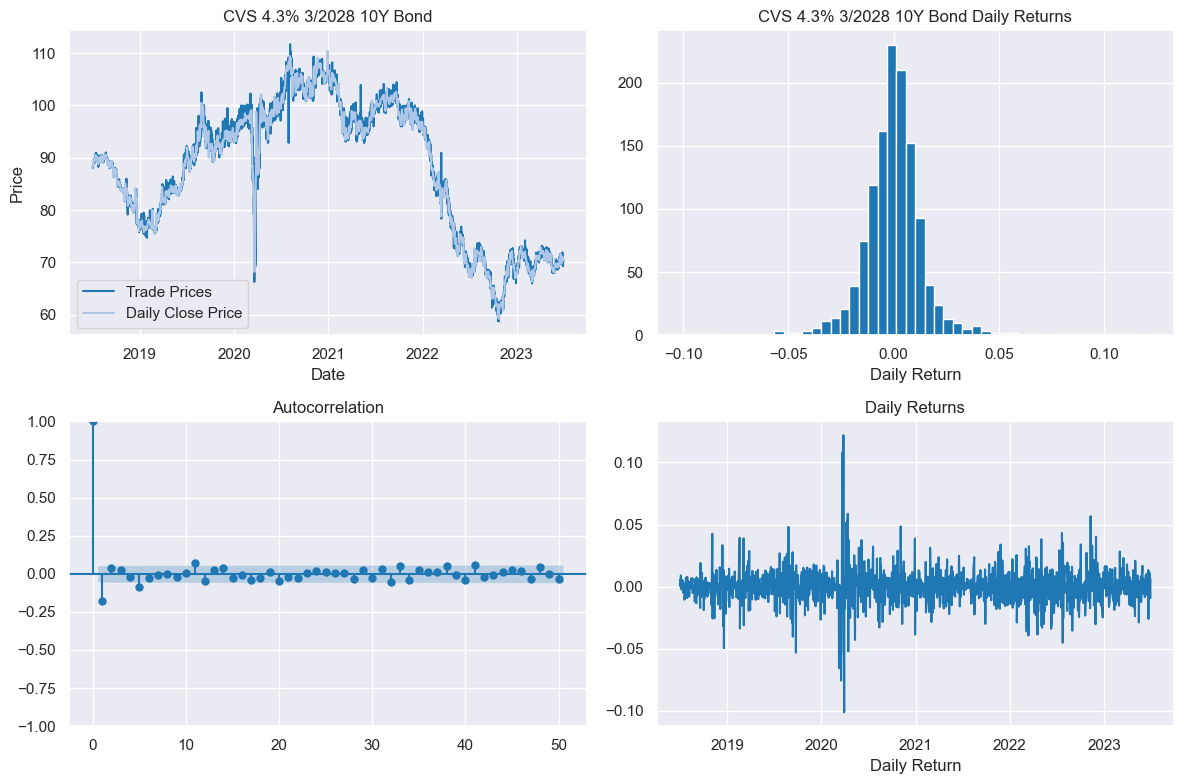

In [235]:
plot_bond(cusip_02209SAV5)

In [262]:
df_02209SAV5 = pd.concat([df_02209SAV5, macro_factors], axis = 1)
df_02209SAV5.head()

,Price,Return,Volume,Trades,Age,TTM,PV,YTM,Duration,DV01,Convexity,Stock,EFFR,Lower_Target,Upper_Target,1YRT,2YRT,3YRT,5YRT,7YRT,10YRT,30YRT,Unemployment,CPI,PCE,IPI,GDP,Real_GDP_cap
2018-07-02,88.2460,NaN,3375000.0,7.0,0.315068,9.736986,88.245954,0.059807,7.812322,-0.689406,70.418236,NaN,1.91,1.75,2.0,2.34,2.57,2.65,2.75,2.83,2.87,2.99,3.8,2.519634,5.36443,3.23564,1.05835,0.46628
2018-07-03,88.7220,0.005394,250000.0,1.0,0.317808,9.734247,88.722155,0.059140,7.815778,-0.693431,70.447570,0.396317,1.91,1.75,2.0,2.33,2.53,2.63,2.72,2.79,2.83,2.96,3.8,2.519634,5.36443,3.23564,1.05835,0.46628
2018-07-05,88.7210,-0.000011,255000.0,2.0,0.323288,9.728767,88.720891,0.059183,7.809978,-0.692909,70.358521,0.785889,1.91,1.75,2.0,2.32,2.55,2.65,2.74,2.80,2.84,2.95,3.8,2.519634,5.36443,3.23564,1.05835,0.46628
2018-07-06,89.5100,0.008893,280000.0,4.0,0.326027,9.726027,89.510090,0.058070,7.817570,-0.699751,70.436046,0.443333,1.91,1.75,2.0,2.34,2.53,2.64,2.71,2.78,2.82,2.94,3.8,2.519634,5.36443,3.23564,1.05835,0.46628
2018-07-09,89.2979,-0.002370,6030000.0,5.0,0.334247,9.717808,89.297927,0.058435,7.805966,-0.697056,70.268235,-0.181366,1.91,1.75,2.0,2.34,2.57,2.66,2.75,2.82,2.86,2.96,3.8,2.519634,5.36443,3.23564,1.05835,0.46628


In [263]:
X = df_02209SAV5.drop(["Return", "Price"], axis = 1)[1:].ffill()
y = df_02209SAV5["Return"][1:].fillna(0)

In [264]:
X0 = sm.add_constant(X)
model = sm.OLS(y, X0).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.109
Date:                Mon, 23 Oct 2023   Prob (F-statistic):            0.00140
Time:                        23:15:21   Log-Likelihood:                 3604.4
No. Observations:                1271   AIC:                            -7159.
Df Residuals:                    1246   BIC:                            -7030.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0108      0.005      1.987   

In [265]:
X_train = X.loc[:pd.Timestamp("2022-05-31")]
X_test = X.loc[pd.Timestamp("2022-06-01"):]
y_train = y.loc[:pd.Timestamp("2022-05-31")]
y_test = y.loc[pd.Timestamp("2022-06-01"):]

In [266]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

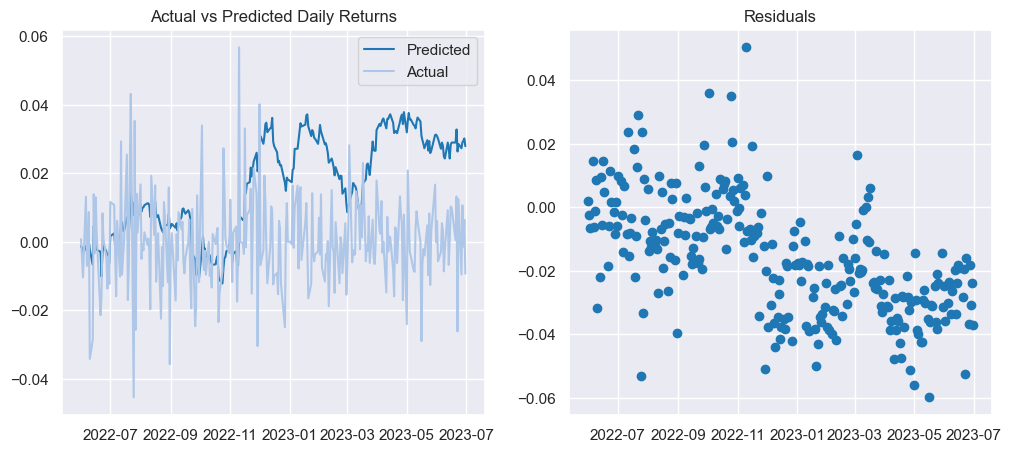

In [267]:
fig, ax = plt.subplots(1, 2, figsize = [12,5])

ax[0].plot(y_test.index, y_pred, label = "Predicted")
ax[0].plot(y_test.index, y_test, label = "Actual")
ax[0].set_title("Actual vs Predicted Daily Returns")
ax[0].legend()

ax[1].scatter(y_test.index, y_test-y_pred)
ax[1].set_title("Residuals")

plt.show()

In [268]:
mse = mean_squared_error(y_test, y_pred)
mse

0.0005886928609760331

In [269]:
r2 = r2_score(y_test, y_pred)
r2

-2.43800896340013